In [24]:
from qiskit import QuantumCircuit, Aer
from qiskit import BasicAer
from qiskit.utils import QuantumInstance
from qiskit_machine_learning.datasets import ad_hoc_data
from qiskit.algorithms.state_fidelities import ComputeUncompute
from qiskit.circuit.library import TwoLocal
from qiskit.algorithms.optimizers import COBYLA
from qiskit.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.cluster import SpectralClustering
from sklearn.metrics import normalized_mutual_info_score

import pandas as pd
import seaborn as sns
import numpy as np
import time
import psutil
from matplotlib import pyplot as plt
from IPython.display import clear_output

# Set seed for random generators
algorithm_globals.random_seed = 42



## Support functions

In [25]:
# Define functions to measure accuracy and resource consumption
def measure_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return classification_report(y_test, y_pred, output_dict=True)['accuracy']


def measure_resources():
    cpu = psutil.cpu_percent()
    memory = psutil.virtual_memory().percent
    return cpu, memory  


# Load the data

In [26]:
from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.datasets import load_breast_cancer

# Load data
iris_data = load_iris()
wine_data = load_wine()
breast_cancer_data = load_breast_cancer()


# Process Data

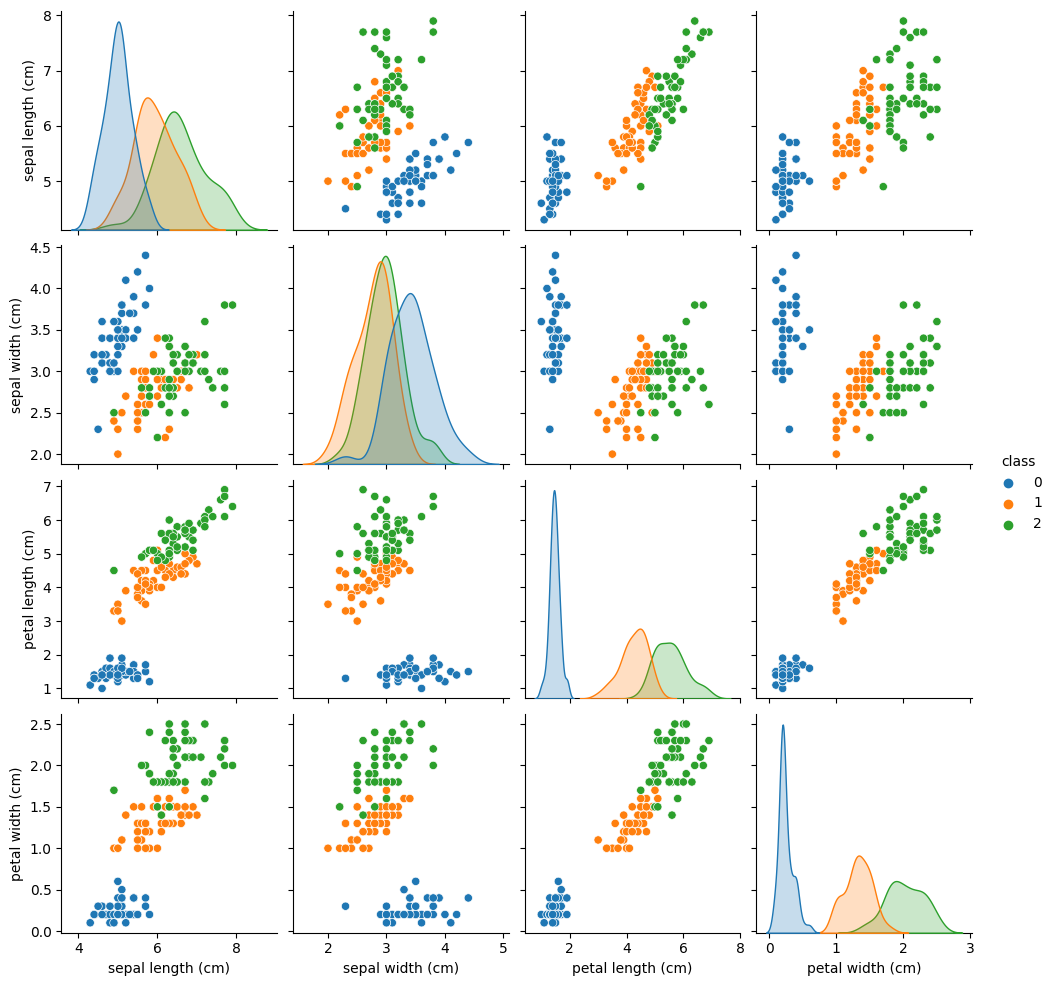

In [27]:
iris_features = iris_data.data
iris_labels = iris_data.target

iris_features = MinMaxScaler().fit_transform(iris_features)

iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df["class"] = pd.Series(iris_data.target)

sns.pairplot(iris_df, hue="class", palette="tab10")


# Process wine data

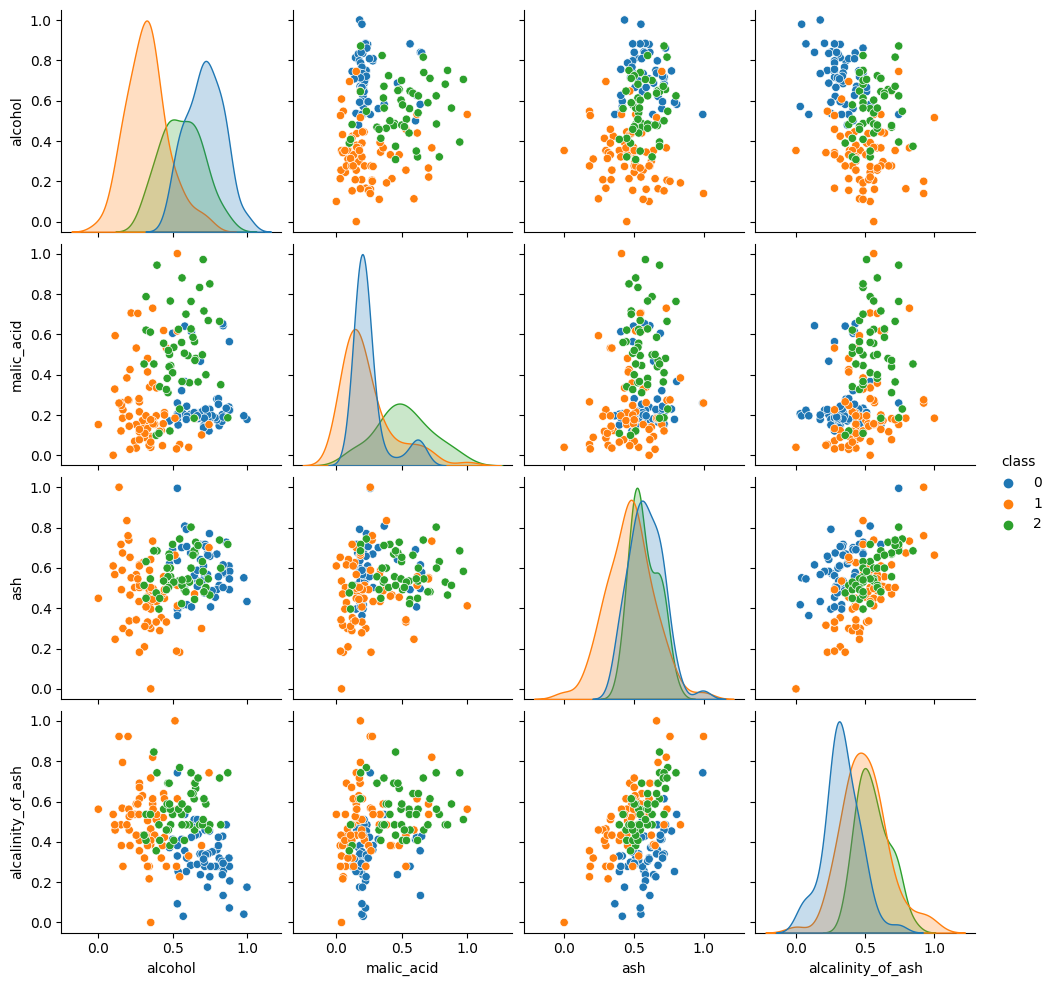

In [28]:
# Limit wine data to 4 features using PCA
wine_features = wine_data.data
wine_labels = wine_data.target

# Apply MinMaxScaler to scale the features
wine_features = MinMaxScaler().fit_transform(wine_features)

# Apply PCA to reduce the number of features to 4
pca = PCA(n_components=4)
wine_features = pca.fit_transform(wine_features)

# Create a DataFrame with the reduced features and class labels
wine_df = pd.DataFrame(wine_features, columns=[
                       'feature1', 'feature2', 'feature3', 'feature4'])
wine_df["class"] = pd.Series(wine_data.target)

# Create a pairplot of the reduced features with class labels as hue
sns.pairplot(wine_df, hue="class", palette="tab10")
plt.show()


# Process breast cancer data

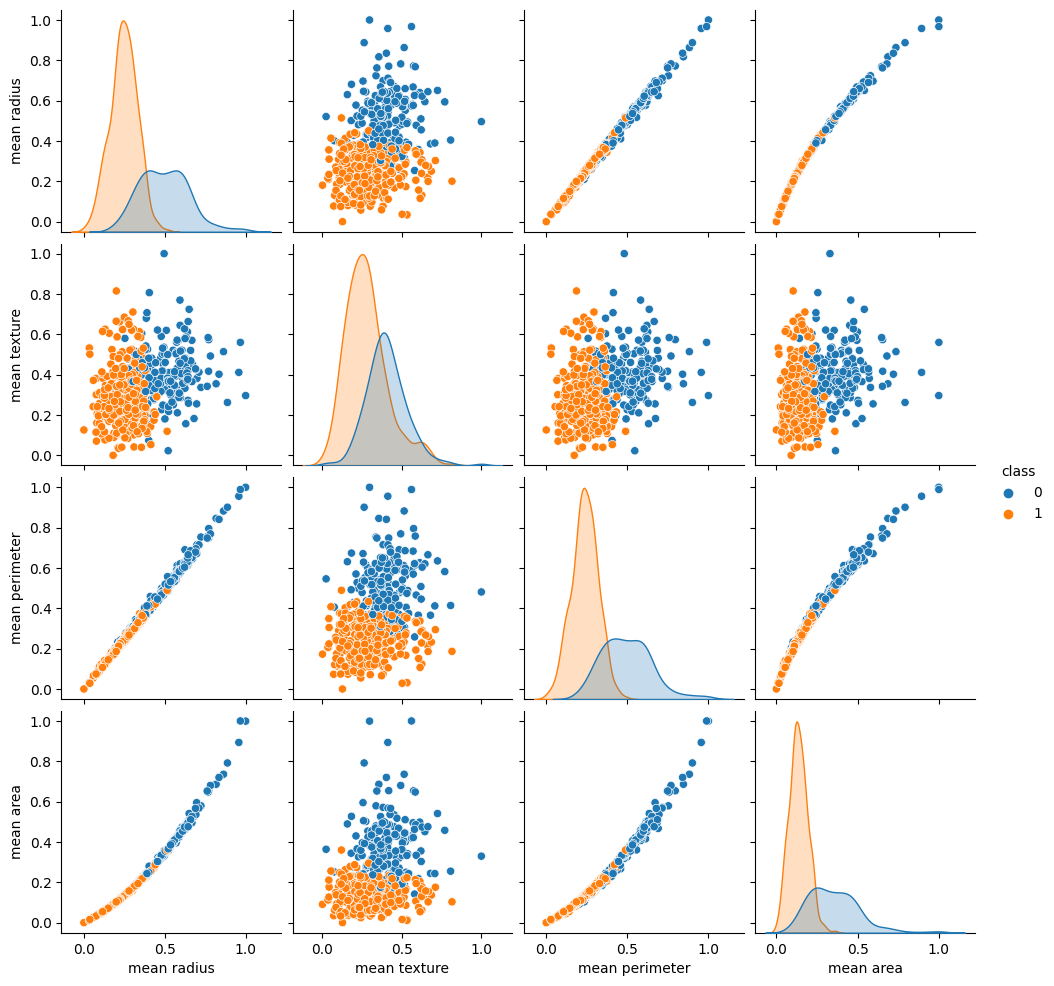

In [29]:
# Limit breast cancer data to 4 features
breast_cancer_features = breast_cancer_data.data
breast_cancer_labels = breast_cancer_data.target

# Apply MinMaxScaler to scale the features
breast_cancer_features = MinMaxScaler().fit_transform(breast_cancer_features)

# Apply PCA to reduce the number of features to 4
pca = PCA(n_components=4)
breast_cancer_features = pca.fit_transform(breast_cancer_features)

# Create a DataFrame with the reduced features and class labels
breast_cancer_df = pd.DataFrame(
    breast_cancer_features, columns=['feature1', 'feature2', 'feature3', 'feature4'])
breast_cancer_df["class"] = pd.Series(breast_cancer_data.target)

# Create a pairplot of the reduced features with class labels as hue
sns.pairplot(breast_cancer_df, hue="class", palette="tab10")
plt.show()


In [30]:
# Split iris data
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    iris_features, iris_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)


In [31]:
# Split wine data
train_features_wine, test_features_wine, train_labels_wine, test_labels_wine = train_test_split(
    wine_features, wine_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [32]:
# Split breast cancer data
train_features_breast_cancer, test_features_breast_cancer, train_labels_breast_cancer, test_labels_breast_cancer = train_test_split(
    breast_cancer_features, breast_cancer_labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

# Iris Classifier

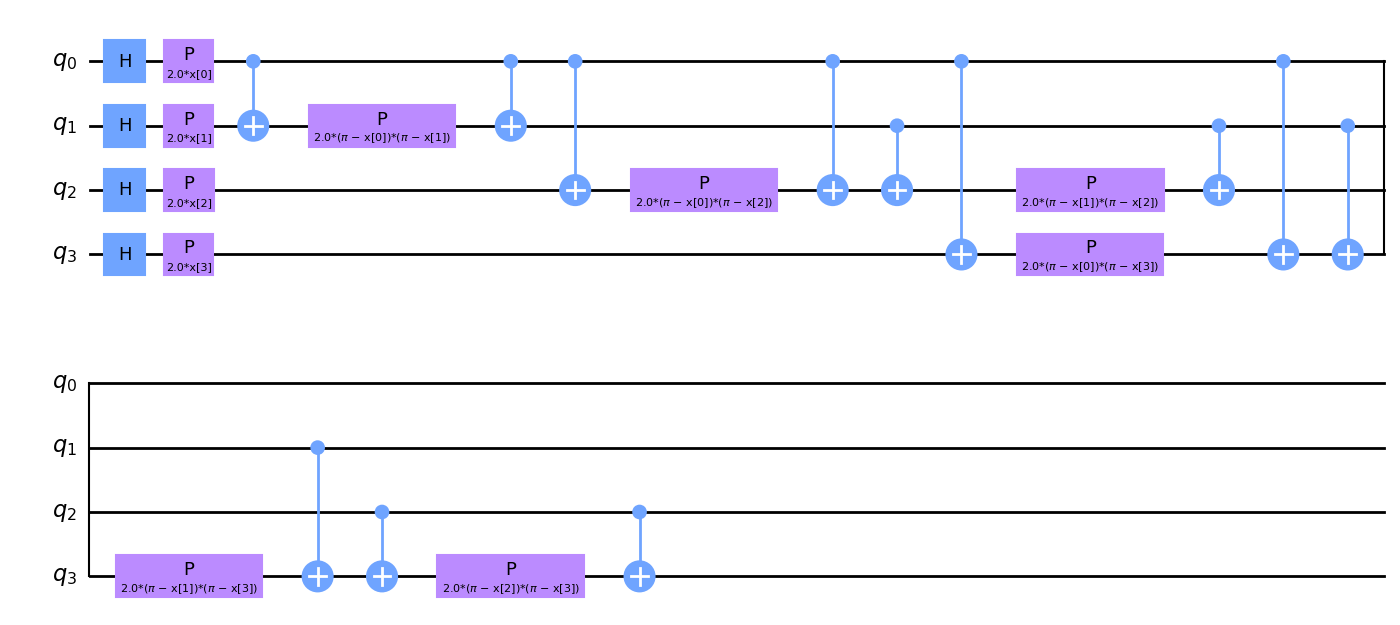

In [33]:
# Create feature map

num_iris_features = iris_features.shape[1]

iris_feature_map = ZZFeatureMap(feature_dimension=num_iris_features, reps=1)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
iris_kernel = FidelityQuantumKernel(
    fidelity=fidelity, feature_map=iris_feature_map)

iris_feature_map.decompose().draw(output="mpl", fold=20)


## Create Callable Iris Classifier

In [34]:
iris_svc = SVC(kernel=iris_kernel.evaluate)
iris_svc.fit(train_features, train_labels)
iris_score = iris_svc.score(test_features, test_labels)

print(f"Callable kernel classification test score: {iris_score}")


Callable kernel classification test score: 0.9666666666666667


In [35]:
qsvc = QSVC(quantum_kernel=iris_kernel)
qsvc.fit(train_features, train_labels)
qsvc_score = qsvc.score(test_features, test_labels)

print(f"QSVC classification test score: {qsvc_score}")


QSVC classification test score: 0.9666666666666667


# Wine classifier

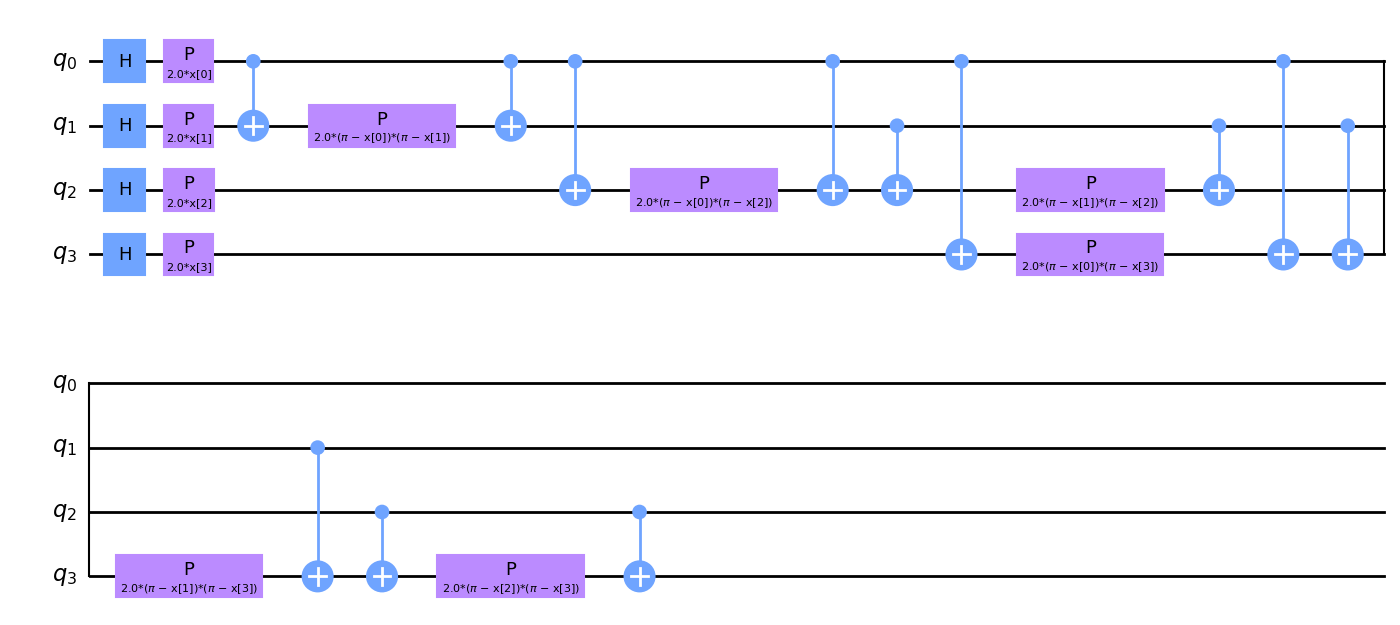

In [36]:
# create wine feature map

num_wine_features = wine_features.shape[1]

wine_feature_map = ZZFeatureMap(feature_dimension=num_wine_features, reps=1)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
wine_kernel = FidelityQuantumKernel(
    fidelity=fidelity, feature_map=wine_feature_map)

wine_feature_map.decompose().draw(output="mpl", fold=20)


## Create Callable Wine Classifier

In [37]:
wine_svc = SVC(kernel=wine_kernel.evaluate)
wine_svc.fit(train_features_wine, train_labels_wine)
wine_score = wine_svc.score(test_features_wine, test_labels_wine)

print(f"Callable kernel classification test score: {wine_score}")

Callable kernel classification test score: 0.7222222222222222


In [38]:
wine_qsvc = QSVC(quantum_kernel=wine_kernel)
wine_qsvc.fit(train_features_wine, train_labels_wine)
wine_qsvc_score = wine_qsvc.score(test_features_wine, test_labels_wine)

print(f"QSVC classification test score: {wine_qsvc_score}")

QSVC classification test score: 0.7222222222222222


# Breast Cancer Classifier

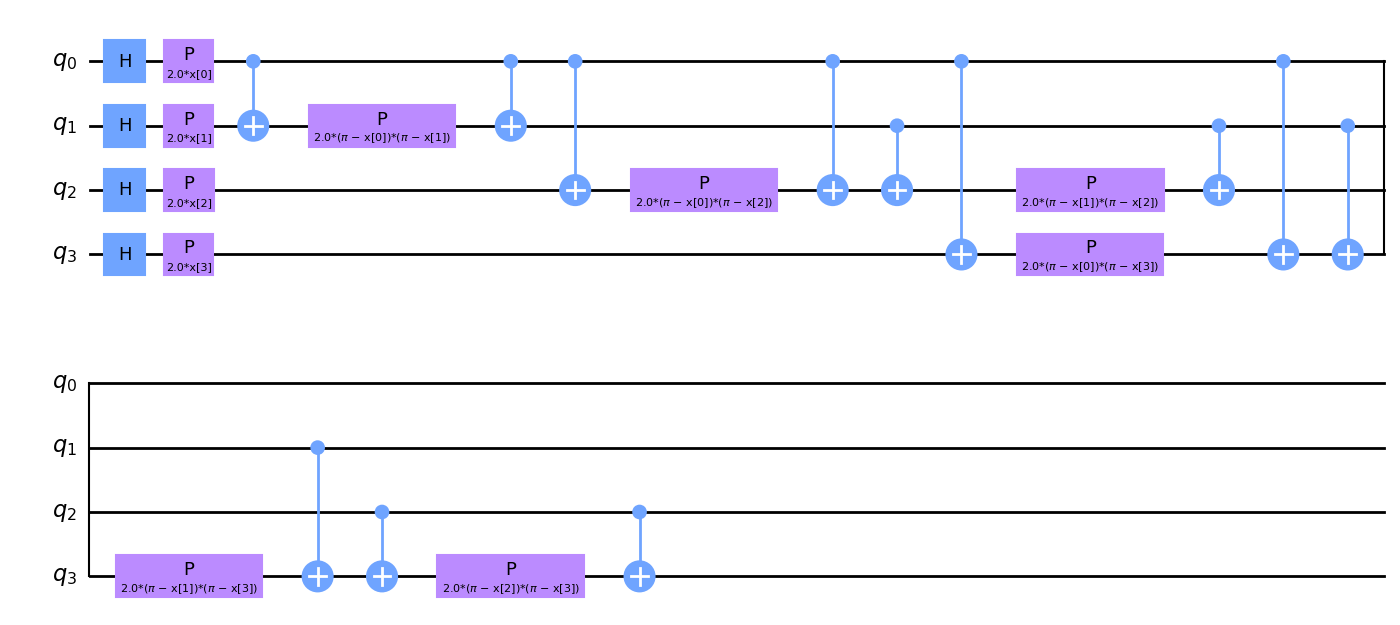

In [39]:
num_breast_cancer_features = breast_cancer_features.shape[1]

breast_cancer_feature_map = ZZFeatureMap(feature_dimension=num_breast_cancer_features, reps=1)
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
breast_cancer_kernel = FidelityQuantumKernel(
    fidelity=fidelity, feature_map=breast_cancer_feature_map)

breast_cancer_feature_map.decompose().draw(output="mpl", fold=20)

## Create Callable Wine Classifier

In [40]:
breast_cancer_svc = SVC(kernel=breast_cancer_kernel.evaluate)
breast_cancer_svc.fit(train_features_breast_cancer, train_labels_breast_cancer)
breast_cancer_score = breast_cancer_svc.score(test_features_breast_cancer, test_labels_breast_cancer)

print(f"Callable kernel classification test score: {breast_cancer_score}")

Callable kernel classification test score: 0.9298245614035088


In [41]:
breast_cancer_qsvc = QSVC(quantum_kernel=breast_cancer_kernel)
breast_cancer_qsvc.fit(train_features_breast_cancer, train_labels_breast_cancer)
breast_cancer_qsvc_score = breast_cancer_qsvc.score(test_features_breast_cancer, test_labels_breast_cancer)

print(f"QSVC classification test score: {breast_cancer_qsvc_score}")

QSVC classification test score: 0.9298245614035088


# Iris Results:

In [43]:
train_score_q4 = qsvc.score(train_features, train_labels)
test_score_q4 = qsvc.score(test_features, test_labels)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")


Quantum VQC on the training dataset: 0.99
Quantum VQC on the test dataset:     0.97


# Wine Results:

In [45]:
train_score_q4_wine = wine_qsvc.score(
    train_features_wine, train_labels_wine)
test_score_q4_wine = wine_qsvc.score(test_features_wine, test_labels_wine)

print(f"Quantum VQC on the training dataset: {train_score_q4_wine:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_wine:.2f}")

Quantum VQC on the training dataset: 0.93
Quantum VQC on the test dataset:     0.72


# Breast Cancer Results:

In [44]:
train_score_q4_breast_cancer = breast_cancer_qsvc.score(
    train_features_breast_cancer, train_labels_breast_cancer)
test_score_q4_breast_cancer = breast_cancer_qsvc.score(
    test_features_breast_cancer, test_labels_breast_cancer)

print(f"Quantum VQC on the training dataset: {train_score_q4_breast_cancer:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4_breast_cancer:.2f}")

Quantum VQC on the training dataset: 0.91
Quantum VQC on the test dataset:     0.93


# Measure other Results:

In [46]:
# Accuracy and resources for iris dataset
accuracy_iris = measure_accuracy(qsvc, test_features, test_labels)
memory_iris, cpu_iris = measure_resources() 

# Accuracy and resources for wine dataset
accuracy_wine = measure_accuracy(
    wine_qsvc, test_features_wine, test_labels_wine)
memory_wine, cpu_wine = measure_resources()

# Accuracy and resources for breast cancer dataset
accuracy_breast_cancer = measure_accuracy(
    breast_cancer_qsvc, test_features_breast_cancer, test_labels_breast_cancer)
memory_breast_cancer, cpu_breast_cancer = measure_resources()


# Print results to a csv

In [47]:
# Create table of results

results = pd.DataFrame( 
    {
        "Dataset": ["Iris", "Wine", "Breast Cancer"],
        "Train Score": [train_score_q4, train_score_q4_wine, train_score_q4_breast_cancer],
        "Test Score": [test_score_q4, test_score_q4_wine, test_score_q4_breast_cancer],
        "Accuracy": [accuracy_iris, accuracy_wine, accuracy_breast_cancer],
        "Memory": [memory_iris, memory_wine, memory_breast_cancer],
        "CPU": [cpu_iris, cpu_wine, cpu_breast_cancer],

    }
)

# Print results to a csv file

results.to_csv("QSVC_results.csv", index=False)